In [1]:
import requests
import sys
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, \
    mean_squared_log_error, median_absolute_error, r2_score
from scipy.stats import pearsonr
import os
import eli5
import json

In [2]:
pd.set_option(
    'display.float_format',
    lambda x: '%.5f' % x
)

In [3]:
FEATURE_VECTOR = ['query_num_of_columns',
                  'query_num_of_rows',
                  'query_row_column_ratio',
                  'query_max_skewness',
                  'query_max_kurtosis',
                  'query_max_unique',
                  'candidate_num_of_columns',
                  'candidate_num_rows',
                  'candidate_row_column_ratio',
                  'candidate_max_skewness',
                  'candidate_max_kurtosis',
                  'candidate_max_unique',
                  'query_target_max_pearson',
                  'query_target_max_spearman',
                  'query_target_max_covariance',
                  'query_target_max_mutual_info',
                  'candidate_target_max_pearson',
                  'candidate_target_max_spearman',
                  'candidate_target_max_covariance',
                  'candidate_target_max_mutual_info',
                  'max_pearson_difference',
                  'containment_fraction']
RELATIVE_GAIN_COLUMN_NAME = 'gain_in_r2_score'
SCORE_BEFORE_COLUMN_NAME = 'r2_score_before'
SCORE_AFTER_COLUMN_NAME = 'r2_score_after'
ABSOLUTE_GAIN_COLUMN_NAME = 'absolute_gain_r2'

In [4]:
def print_df(df):
    """Prints entire pandas dataframe.
    """
    with pd.option_context('display.max_rows', None,
                           'display.max_columns', None,
                           'display.expand_frame_repr', False,
                           'display.max_colwidth', 60):
        print(df)

In [5]:
def get_dataset_name(id_):
    """Connects to Datamart to get the dataset name, given the dataset id.
    """
    
    success = False
    while not success:
        try:
            response = requests.get(
                'http://localhost:8002/metadata/%s'%id_,
            )
            response.raise_for_status()
            success = True
        except Exception as e:
            continue
    
    return json.loads(response.text)['metadata']['name']

In [6]:
def compute_pearson(df, col_1, col_2):
    return pearsonr(df[col_1], df[col_2])[0]

## Classification

In [7]:
def create_model(alpha, training_filename, feature_vector, target_column):
    """This functions builds a classifier based on the training data.
    """
    
    training_data = pd.read_csv(training_filename)
    training_data['class'] = ['gain' if row[target_column] > alpha else 'loss'
                              for index, row in training_data.iterrows()]
    X_train = training_data[feature_vector]
    y_train = training_data['class']
    
    clf = RandomForestClassifier(random_state=49, n_estimators=100)
    clf.fit(X_train, y_train)
    
    return clf

In [8]:
def predict_class_for_features(classifier, test_filename, feature_vector, target_column):

    test_data = pd.read_csv(test_filename)
    
    # avoiding overflow
    for col in test_data.select_dtypes([np.number]).columns:
        test_data = test_data[test_data[col] < np.finfo(np.float32).max]
    test_data.reset_index(inplace=True)
    X_test = test_data[feature_vector]
    
    # replacing NaN values
    if X_test.isna().values.any():
        X_test.fillna(value=0, inplace=True)
        
    predicted_classes = classifier.predict(X_test)
    predicted_proba = classifier.predict_proba(X_test)
    
    explanations = list()
    for index, row in X_test.iterrows():
        explanations.append(eli5.explain_prediction_df(classifier, X_test.iloc[index]))
    
    test_data['class'] = predicted_classes
    test_data['candidate_id'] = test_data['candidate'].apply(
        lambda x: os.path.basename(x)
    )
    test_data['candidate_name'] = test_data['candidate_id'].apply(
        lambda x: get_dataset_name(x[:x.find('_')])
    )
    test_data.rename(columns={'containment_fraction': 'cf'}, inplace=True)
    test_data.rename(columns={target_column: 'g_r2'}, inplace=True)
    
    probabilities = pd.DataFrame(predicted_proba, columns=list(classifier.classes_))
    test_data['p(gain)'] = probabilities['gain']
    test_data['p(loss)'] = probabilities['loss']
    
    new_test_data = test_data[
        ['candidate_name', 'candidate_id', 'cf', 'g_r2', 'class', 'p(gain)', 'p(loss)']
    ].sort_values('g_r2', ascending=False)
    new_test_data.reset_index(drop=True, inplace=True)
    
    return (new_test_data, explanations)

In [9]:
def compute_precision_recall(df, print_records=True):
    
    tp_vals = list()
    index_tp = list()
    fp_vals = list()
    index_fp = list()
    tn_vals = list()
    index_tn = list()
    fn_vals = list()
    index_fn = list()
    
    for index, row in df.iterrows():
        if row['g_r2'] > 0 and row['class'] == 'gain':
            tp_vals.append([row['candidate_name'], row['g_r2'], row['p(gain)'], row['cf']])
            index_tp.append(index)
        elif row['g_r2'] > 0 and row['class'] == 'loss':
            fn_vals.append([row['candidate_name'], row['g_r2'], row['p(gain)'], row['cf']])
            index_fn.append(index)
        elif row['g_r2'] <= 0 and row['class'] == 'gain':
            fp_vals.append([row['candidate_name'], row['g_r2'], row['p(gain)'], row['cf']])
            index_fp.append(index)
        else:
            tn_vals.append([row['candidate_name'], row['g_r2'], row['p(gain)'], row['cf']])
            index_tn.append(index)
            
    tp = len(tp_vals)
    fn = len(fn_vals)
    fp = len(fp_vals)
    tn = len(tn_vals)
            
    columns = ['name', 'g_r2', 'p(gain)', 'cf']
    tp_df = pd.DataFrame(tp_vals, columns=columns, index=index_tp)
    fn_df = pd.DataFrame(fn_vals, columns=columns, index=index_fn)
    fp_df = pd.DataFrame(fp_vals, columns=columns, index=index_fp)
    tn_df = pd.DataFrame(tn_vals, columns=columns, index=index_tn)
            
    print("-- Total:", tp+tn+fp+fn)
    print('')
    print("-- TP:", tp)
    if print_records:
        print_df(tp_df)
    print('')
    print("-- TN:", tn)
    if print_records:
        print_df(tn_df)
    print('')
    print("-- FP:", fp)
    if print_records:
        print_df(fp_df)
    print('')
    print("-- FN:", fn)
    if print_records:
        print_df(fn_df)
    print('')

    precision = tp / (tp + fp) if tp + fp > 0 else np.nan
    recall = tp / (tp + fn) if tp + fn > 0 else np.nan
    
    print('Precision: %.4f\nRecall: %.4f'%(precision, recall))

In [10]:
def predict_class_for_features_and_save(classifier, test_filename, feature_vector, target_column, output_path):

    test_data = pd.read_csv(test_filename)
    
    # avoiding overflow
    for col in test_data.select_dtypes([np.number]).columns:
        test_data = test_data[test_data[col] < np.finfo(np.float32).max]
    test_data.reset_index(inplace=True, drop=True)
    X_test = test_data[feature_vector]
    
    # replacing NaN values
    if X_test.isna().values.any():
        X_test.fillna(value=0, inplace=True)
        
    predicted_classes = classifier.predict(X_test)
    test_data['class'] = predicted_classes
    
    predicted_proba = classifier.predict_proba(X_test)
    probabilities = pd.DataFrame(predicted_proba, columns=list(classifier.classes_))
    test_data['p(gain)'] = probabilities['gain']
    test_data['p(loss)'] = probabilities['loss']
    
    evals = list()
    for index, row in test_data.iterrows():
        if row[target_column] > 0 and row['class'] == 'gain':
            evals.append('tp')
        elif row[target_column] > 0 and row['class'] == 'loss':
            evals.append('fn')
        elif row[target_column] <= 0 and row['class'] == 'gain':
            evals.append('fp')
        else:
            evals.append('tn')
    test_data['eval'] = evals
    
    test_data.to_csv(output_path, index=False)

In [11]:
def remove_gain_halfway(df):
    
    new_df = df.copy()
    new_df = new_df[(new_df['p(gain)'] <= 0.4) | (new_df['p(gain)'] >= 0.6)]
    
    return new_df

In [12]:
rf_classifier = create_model(
    alpha=0,
    training_filename='../data/training-for-model.csv',
    feature_vector=FEATURE_VECTOR,
    target_column=RELATIVE_GAIN_COLUMN_NAME
)

In [120]:
print(
    sorted(
        [[x, y] for x, y in zip(FEATURE_VECTOR, rf_classifier.feature_importances_)],
        key=lambda x: x[1],
        reverse=True
    )
)

[['candidate_target_max_spearman', 0.0712391682544227], ['query_row_column_ratio', 0.06894147852797561], ['candidate_target_max_pearson', 0.06573894584971411], ['max_pearson_difference', 0.059321503459179116], ['query_max_kurtosis', 0.055661619627371976], ['query_num_of_columns', 0.05527159455342409], ['candidate_target_max_mutual_info', 0.05514253414921095], ['candidate_target_max_covariance', 0.05407208166914152], ['candidate_max_skewness', 0.05145447033509972], ['candidate_max_kurtosis', 0.05125604337853765], ['candidate_max_unique', 0.04373400731969874], ['query_max_skewness', 0.041897030995598605], ['candidate_num_rows', 0.04086773469778324], ['candidate_row_column_ratio', 0.04078823682522269], ['containment_fraction', 0.040400243417922456], ['query_target_max_covariance', 0.03963169137391701], ['query_max_unique', 0.03781180496193452], ['query_target_max_spearman', 0.037208490977014334], ['query_target_max_pearson', 0.03621661853592138], ['query_num_of_rows', 0.029079543837156278

In [13]:
rf_classifier_no_max_pearson_diff = create_model(
    alpha=0,
    training_filename='../data/training-for-model.csv',
    feature_vector=list(set(FEATURE_VECTOR).difference(set(['max_pearson_difference']))),
    target_column=RELATIVE_GAIN_COLUMN_NAME
)

## Regression

In [14]:
def create_absolute_gain_column(df, score_before_column, score_after_column, column_name):
    df[column_name] = df[score_after_column] - df[score_before_column]

In [15]:
def create_regression_model_from_df(training_df, feature_vector, target_column):
    """This functions builds a regressor based on the training data (pandas.Dataframe).
    """

    X_train = training_df[feature_vector]
    y_train = training_df[target_column]
    
    regr = RandomForestRegressor(random_state=49, n_estimators=100)
    regr.fit(X_train, y_train)
    
    return regr

In [16]:
def create_regression_model(training_filename, feature_vector, target_column):
    """This functions builds a regressor based on the training data.
    """
    
    training_data = pd.read_csv(training_filename)
    
    return create_regression_model_from_df(training_data, feature_vector, target_column)

In [17]:
def predict_value_for_features_from_df(regressor, test_df, feature_vector, target_column):
    
    # avoiding overflow
    for col in test_df.select_dtypes([np.number]).columns:
        test_df = test_df[test_df[col] < np.finfo(np.float32).max]
    test_df.reset_index(inplace=True)
    X_test = test_df[feature_vector]
    
    # replacing NaN values
    if X_test.isna().values.any():
        X_test.fillna(value=0, inplace=True)
        
    y_fit = regressor.predict(X_test)
    
    explanations = list()
    for index, row in X_test.iterrows():
        explanations.append(eli5.explain_prediction_df(regressor, X_test.iloc[index]))
    
    test_df['predicted'] = y_fit
    test_df['candidate_id'] = test_df['candidate'].apply(
        lambda x: os.path.basename(x)
    )
    test_df['candidate_name'] = test_df['candidate_id'].apply(
        lambda x: get_dataset_name(x[:x.find('_')])
    )
    test_df.rename(columns={'containment_fraction': 'cf'}, inplace=True)
    test_df.rename(columns={target_column: 'real'}, inplace=True)
    
    new_test_data = test_df[
#        ['candidate_name', 'candidate_id', 'cf', 'real', 'predicted']
        ['candidate_name', 'cf', 'real', 'predicted']
    ].sort_values('real', ascending=False)
    new_test_data.reset_index(drop=True, inplace=True)
    
    print("Mean Absolute Error: %.4f" % mean_absolute_error(new_test_data['real'], new_test_data['predicted']))
    print("Mean Squared Error: %.4f" % mean_squared_error(new_test_data['real'], new_test_data['predicted']))
    print("Median Absolute Error: %.4f" % median_absolute_error(new_test_data['real'], new_test_data['predicted']))
    print("R2 Score: %.4f" % r2_score(new_test_data['real'], new_test_data['predicted']))
    
    return (new_test_data, explanations)

In [18]:
def predict_value_for_features(regressor, test_filename, feature_vector, target_column):

    test_data = pd.read_csv(test_filename)
    
    return predict_value_for_features_from_df(
        regressor,
        test_data,
        feature_vector,
        target_column
    )

In [19]:
rf_regressor = create_regression_model(
    training_filename='../data/training-for-model.csv',
    feature_vector=FEATURE_VECTOR,
    target_column=RELATIVE_GAIN_COLUMN_NAME
)

In [20]:
training_df_with_abolute_column = pd.read_csv('../data/training-for-model.csv')
create_absolute_gain_column(
    training_df_with_abolute_column,
    SCORE_BEFORE_COLUMN_NAME,
    SCORE_AFTER_COLUMN_NAME,
    ABSOLUTE_GAIN_COLUMN_NAME
)
rf_regressor_abs = create_regression_model_from_df(
    training_df=training_df_with_abolute_column,
    feature_vector=FEATURE_VECTOR,
    target_column=ABSOLUTE_GAIN_COLUMN_NAME
)

## NY Taxi and Vehicle Collision Problem

### Classification

In [21]:
taxi_vehicle_collision_classes, taxi_vehicle_collision_explanations = predict_class_for_features(
    rf_classifier,
    'taxi-vehicle-collision-records-features',
    FEATURE_VECTOR,
    RELATIVE_GAIN_COLUMN_NAME
)

In [22]:
compute_precision_recall(taxi_vehicle_collision_classes)

-- Total: 76

-- TP: 17
                                                           name    g_r2  p(gain)      cf
0                                              DHS Daily Report 4.43722  0.53000 0.97238
1   Performance Metrics - Buildings - Time to Issue Easy Per... 4.24356  0.61000 0.14365
2   Performance Metrics - Buildings - Time to Issue Easy Per... 4.24356  0.61000 0.14365
3   Performance Metrics - Buildings - Time to Issue Develope... 4.02944  0.52000 0.14365
4   Performance Metrics - Buildings - Time to Issue Develope... 4.02944  0.52000 0.14365
6                       CTA - Ridership - Daily Boarding Totals 2.42632  0.51000 1.00000
7   Performance Metrics - Buildings - Time To Issue Green Pe... 2.09037  0.51000 0.14365
8   Performance Metrics - Buildings - Time To Issue Green Pe... 2.09037  0.51000 0.14365
12                        Cash Assistance Recipients Since 1955 1.31017  0.55000 0.03315
13  Interagency Coordination and Construction Permits Data (... 1.28968  0.51000 0.005

In [23]:
taxi_vehicle_collision_explanations[38]

,target,feature,weight,value
0,gain,<BIAS>,0.55715,1.00000
1,gain,candidate_max_kurtosis,0.04616,2266.00267
2,gain,query_target_max_spearman,0.03262,0.23067
3,gain,query_num_of_columns,0.03104,2.00000
4,gain,candidate_target_max_covariance,0.02868,2056489709.77668
5,gain,candidate_max_unique,0.02814,2365.00000
6,gain,candidate_target_max_mutual_info,0.02294,0.18128
7,gain,query_num_of_rows,0.01941,181.00000
8,gain,candidate_max_skewness,0.01270,47.10386
9,gain,candidate_num_rows,0.00550,2365.00000


In [24]:
compute_precision_recall(taxi_vehicle_collision_classes, print_records=False)

-- Total: 76

-- TP: 17

-- TN: 20

-- FP: 25

-- FN: 14

Precision: 0.4048
Recall: 0.5484


In [25]:
# Pearson between containment fraction and gain in R2
compute_pearson(taxi_vehicle_collision_classes, 'cf', 'g_r2')

0.4056500620662548

In [26]:
# Pearson between containment fraction and probability of being classified as gain
compute_pearson(taxi_vehicle_collision_classes, 'cf', 'p(gain)')

0.09493200349622191

In [27]:
taxi_vehicle_collision_classes.plot.scatter(x='g_r2', y='cf', )

In [28]:
# Pearson between gain in R2 and probability of being classified as gain
compute_pearson(taxi_vehicle_collision_classes, 'g_r2', 'p(gain)')

0.005988255645576356

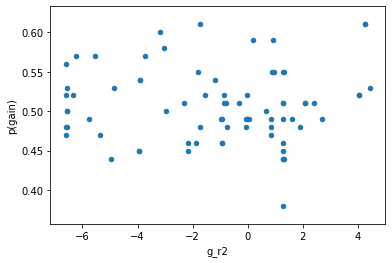

In [29]:
taxi_vehicle_collision_classes.plot.scatter(x='g_r2', y='p(gain)', )

### Classification -- ignoring p(gain) between 0.4 and 0.6

In [30]:
taxi_vehicle_collision_classes_i = remove_gain_halfway(taxi_vehicle_collision_classes)

In [31]:
compute_precision_recall(taxi_vehicle_collision_classes_i)

-- Total: 5

-- TP: 2
                                                          name    g_r2  p(gain)      cf
1  Performance Metrics - Buildings - Time to Issue Easy Per... 4.24356  0.61000 0.14365
2  Performance Metrics - Buildings - Time to Issue Easy Per... 4.24356  0.61000 0.14365

-- TN: 0
Empty DataFrame
Columns: [name, g_r2, p(gain), cf]
Index: []

-- FP: 2
                           name     g_r2  p(gain)      cf
47         311 Cases by Channel -1.73887  0.61000 0.03315
55  Bikes in Buildings Requests -3.17779  0.60000 0.03315

-- FN: 1
                             name    g_r2  p(gain)      cf
19  NYCHA Citywide Special Events 1.28968  0.38000 0.02762

Precision: 0.5000
Recall: 0.6667


In [32]:
compute_precision_recall(taxi_vehicle_collision_classes_i, print_records=False)

-- Total: 5

-- TP: 2

-- TN: 0

-- FP: 2

-- FN: 1

Precision: 0.5000
Recall: 0.6667


In [33]:
# Pearson between containment fraction and gain in R2
compute_pearson(taxi_vehicle_collision_classes_i, 'cf', 'g_r2')

0.8628277794124862

In [34]:
# Pearson between containment fraction and probability of being classified as gain
compute_pearson(taxi_vehicle_collision_classes_i, 'cf', 'p(gain)')

0.4630443018905789

In [35]:
# Pearson between gain in R2 and probability of being classified as gain
compute_pearson(taxi_vehicle_collision_classes_i, 'g_r2', 'p(gain)')

-0.022829967479567878

### Classification (Single Column)

In [36]:
taxi_vehicle_collision_classes_single_column, taxi_vehicle_collision_explanations_single_column = predict_class_for_features(
    rf_classifier,
    'taxi-vehicle-collision-records-features-single-column',
    FEATURE_VECTOR,
    RELATIVE_GAIN_COLUMN_NAME
)

In [37]:
compute_precision_recall(taxi_vehicle_collision_classes_single_column)

-- Total: 447

-- TP: 178
                                                            name    g_r2  p(gain)      cf
0    Performance Metrics - Buildings - Time to Issue Easy Per... 3.50295  0.61000 0.14365
1    Performance Metrics - Buildings - Time to Issue Easy Per... 3.50295  0.61000 0.14365
5    Gasoline Retail Prices Weekly Average by Region: Beginni... 3.20641  0.63000 0.14365
6    Gasoline Retail Prices Weekly Average by Region: Beginni... 3.11150  0.58000 0.14365
7    Gasoline Retail Prices Weekly Average by Region: Beginni... 3.10606  0.57000 0.14365
8    Performance Metrics - Buildings - Time to Issue Develope... 3.02843  0.56000 0.14365
9    Performance Metrics - Buildings - Time to Issue Develope... 3.02843  0.56000 0.14365
11   Diesel Retail Price Weekly Average by Region: Beginning ... 2.97197  0.50000 0.14365
17   Diesel Retail Price Weekly Average by Region: Beginning ... 2.78959  0.51000 0.14365
22                                              DHS Daily Report 2.27799  

In [38]:
compute_precision_recall(taxi_vehicle_collision_classes_single_column, print_records=False)

-- Total: 447

-- TP: 178

-- TN: 0

-- FP: 0

-- FN: 269

Precision: 1.0000
Recall: 0.3982


In [39]:
# Pearson between containment fraction and gain in R2
compute_pearson(taxi_vehicle_collision_classes_single_column, 'cf', 'g_r2')

0.17502218541786999

In [40]:
# Pearson between containment fraction and probability of being classified as gain
compute_pearson(taxi_vehicle_collision_classes_single_column, 'cf', 'p(gain)')

0.06954693200163102

In [41]:
# Pearson between gain in R2 and probability of being classified as gain
compute_pearson(taxi_vehicle_collision_classes_single_column, 'g_r2', 'p(gain)')

0.08089977758211736

### Classification (Single Column) -- ignoring p(gain) between 0.4 and 0.6

In [42]:
taxi_vehicle_collision_classes_single_column_i = remove_gain_halfway(taxi_vehicle_collision_classes_single_column)

In [43]:
compute_precision_recall(taxi_vehicle_collision_classes_single_column_i)

-- Total: 41

-- TP: 25
                                                            name    g_r2  p(gain)      cf
0    Performance Metrics - Buildings - Time to Issue Easy Per... 3.50295  0.61000 0.14365
1    Performance Metrics - Buildings - Time to Issue Easy Per... 3.50295  0.61000 0.14365
5    Gasoline Retail Prices Weekly Average by Region: Beginni... 3.20641  0.63000 0.14365
23                                              DHS Daily Report 2.14597  0.61000 0.97238
42                                          311 Cases by Channel 1.41322  0.62000 0.03315
43             Call Center Metrics for the Health Service System 1.41322  0.63000 0.03315
79                                   Bikes in Buildings Requests 1.30186  0.63000 0.02762
80                               SF Development Pipeline 2018 Q3 1.29797  0.61000 0.07735
82                               SF Development Pipeline 2018 Q3 1.29694  0.61000 0.07735
83                               SF Development Pipeline 2018 Q3 1.29694  0.

In [44]:
compute_precision_recall(taxi_vehicle_collision_classes_single_column_i, print_records=False)

-- Total: 41

-- TP: 25

-- TN: 0

-- FP: 0

-- FN: 16

Precision: 1.0000
Recall: 0.6098


In [45]:
# Pearson between containment fraction and gain in R2
compute_pearson(taxi_vehicle_collision_classes_single_column_i, 'cf', 'g_r2')

0.30828835022146456

In [46]:
# Pearson between containment fraction and probability of being classified as gain
compute_pearson(taxi_vehicle_collision_classes_single_column_i, 'cf', 'p(gain)')

0.10402278881198346

In [47]:
# Pearson between gain in R2 and probability of being classified as gain
compute_pearson(taxi_vehicle_collision_classes_single_column_i, 'g_r2', 'p(gain)')

0.2692072541270025

### Regression

In [48]:
taxi_vehicle_collision_predictions, taxi_vehicle_collision_regr_explanations = predict_value_for_features(
    rf_regressor,
    'taxi-vehicle-collision-records-features',
    FEATURE_VECTOR,
    RELATIVE_GAIN_COLUMN_NAME
)

Mean Absolute Error: 73.3421
Mean Squared Error: 13669.3949
Median Absolute Error: 23.5761
R2 Score: -1402.1623


In [49]:
print_df(taxi_vehicle_collision_predictions)

                                                 candidate_name      cf     real  predicted
0                                              DHS Daily Report 0.97238  4.43722  179.42432
1   Performance Metrics - Buildings - Time to Issue Easy Per... 0.14365  4.24356   10.91315
2   Performance Metrics - Buildings - Time to Issue Easy Per... 0.14365  4.24356   10.91315
3   Performance Metrics - Buildings - Time to Issue Develope... 0.14365  4.02944    3.02986
4   Performance Metrics - Buildings - Time to Issue Develope... 0.14365  4.02944    3.02986
5                                     Daily Weather Data for NY 1.00000  2.69791  180.61858
6                       CTA - Ridership - Daily Boarding Totals 1.00000  2.42632  180.87837
7   Performance Metrics - Buildings - Time To Issue Green Pe... 0.14365  2.09037    2.54227
8   Performance Metrics - Buildings - Time To Issue Green Pe... 0.14365  2.09037    2.54227
9             Lottery Powerball Winning Numbers: Beginning 2010 0.24862  1.89893

In [50]:
taxi_vehicle_collision_regr_explanations[5]

,target,feature,weight,value
0,y,query_target_max_pearson,398.82819,0.03657
1,y,candidate_target_max_covariance,192.46929,9551887.31111
2,y,candidate_target_max_spearman,128.94593,0.01271
3,y,candidate_max_kurtosis,24.90749,0.35314
4,y,candidate_row_column_ratio,4.76178,124.00000
5,y,<BIAS>,2.00898,1.00000
6,y,candidate_max_skewness,0.34652,0.64483
7,y,query_target_max_covariance,0.23068,176158.30261
8,y,query_target_max_spearman,0.12862,0.23067
9,y,candidate_target_max_mutual_info,0.12682,0.19854


### Regression -- absolute diff in R2 score

In [51]:
taxi_vehicle_collision_records_features = pd.read_csv('taxi-vehicle-collision-records-features')
create_absolute_gain_column(
    taxi_vehicle_collision_records_features,
    SCORE_BEFORE_COLUMN_NAME,
    SCORE_AFTER_COLUMN_NAME,
    ABSOLUTE_GAIN_COLUMN_NAME
)
taxi_vehicle_collision_predictions_abs, taxi_vehicle_collision_regr_explanations_abs = predict_value_for_features_from_df(
    rf_regressor_abs,
    taxi_vehicle_collision_records_features,
    FEATURE_VECTOR,
    ABSOLUTE_GAIN_COLUMN_NAME
)

Mean Absolute Error: 0.1603
Mean Squared Error: 0.0463
Median Absolute Error: 0.1137
R2 Score: -0.5027


In [52]:
print_df(taxi_vehicle_collision_predictions_abs)

                                                 candidate_name      cf     real  predicted
0                                              DHS Daily Report 0.97238  0.24945    0.05617
1   Performance Metrics - Buildings - Time to Issue Easy Per... 0.14365  0.23857    0.07959
2   Performance Metrics - Buildings - Time to Issue Easy Per... 0.14365  0.23857    0.07959
3   Performance Metrics - Buildings - Time to Issue Develope... 0.14365  0.22653    0.03868
4   Performance Metrics - Buildings - Time to Issue Develope... 0.14365  0.22653    0.03868
5                                     Daily Weather Data for NY 1.00000  0.15167    0.01480
6                       CTA - Ridership - Daily Boarding Totals 1.00000  0.13640    0.06480
7   Performance Metrics - Buildings - Time To Issue Green Pe... 0.14365  0.11752    0.05979
8   Performance Metrics - Buildings - Time To Issue Green Pe... 0.14365  0.11752    0.05979
9             Lottery Powerball Winning Numbers: Beginning 2010 0.24862  0.10676

## College Debt

### Classification

In [53]:
college_debt_classes, college_debt_explanations = predict_class_for_features(
    rf_classifier,
    'college-debt-records-features',
    FEATURE_VECTOR,
    RELATIVE_GAIN_COLUMN_NAME
)

In [54]:
compute_precision_recall(college_debt_classes)

-- Total: 41

-- TP: 20
                                                           name    g_r2  p(gain)      cf
0                    Most- Recent- Cohorts- Scorecard- Elements 0.80812  0.79000 1.00000
1                          College Scorecard Data - Most Recent 0.72774  0.80000 1.00000
2    Chicago Public Schools - School Profile Information SY1617 0.01031  0.58000 0.00020
3    Chicago Public Schools - School Profile Information SY1718 0.00983  0.58000 0.00020
4                                Public Pay Telephone Locations 0.00903  0.57000 0.01222
5                                            Muni Simple Routes 0.00780  0.67000 0.00200
6       Chicago Public Schools - School Progress Reports SY1819 0.00718  0.58000 0.00020
7                          Lobbyist Data - Expenditures - Small 0.00703  0.57000 0.00160
8    Chicago Public Schools - School Profile Information SY1819 0.00700  0.58000 0.00020
9       Chicago Public Schools - School Progress Reports SY1516 0.00653  0.58000 0.000

In [55]:
compute_precision_recall(college_debt_classes, print_records=False)

-- Total: 41

-- TP: 20

-- TN: 0

-- FP: 21

-- FN: 0

Precision: 0.4878
Recall: 1.0000


In [56]:
# Pearson between containment fraction and gain in R2
compute_pearson(college_debt_classes, 'cf', 'g_r2')

0.7769692883819711

In [57]:
# Pearson between containment fraction and probability of being classified as gain
compute_pearson(college_debt_classes, 'cf', 'p(gain)')

0.8045740496116186

In [58]:
# Pearson between gain in R2 and probability of being classified as gain
compute_pearson(college_debt_classes, 'g_r2', 'p(gain)')

0.6433680005970396

### Classification -- ignoring p(gain) between 0.4 and 0.6

In [59]:
college_debt_classes_i = remove_gain_halfway(college_debt_classes)

In [60]:
compute_precision_recall(college_debt_classes_i)

-- Total: 10

-- TP: 5
                                               name    g_r2  p(gain)      cf
0        Most- Recent- Cohorts- Scorecard- Elements 0.80812  0.79000 1.00000
1              College Scorecard Data - Most Recent 0.72774  0.80000 1.00000
5                                Muni Simple Routes 0.00780  0.67000 0.00200
15            Alternative Fuel Stations in New York 0.00472  0.60000 0.00240
18  Chicago Energy Benchmarking - Covered Buildings 0.00305  0.60000 0.01042

-- TN: 0
Empty DataFrame
Columns: [name, g_r2, p(gain), cf]
Index: []

-- FP: 5
                                          name     g_r2  p(gain)      cf
26  Most- Recent- Cohorts- Scorecard- Elements -0.08209  0.76000 0.93427
27        Parking Signs / Street Space Permits -0.08284  0.63000 0.00481
37              Inclusionary Housing Transfers -0.08722  0.70000 0.00040
39   Inclusionary Housing Floor Area Generated -0.09302  0.63000 0.00020
40                    Daily Inmates In Custody -0.09412  0.67000 0.00

In [61]:
compute_precision_recall(college_debt_classes_i, print_records=False)

-- Total: 10

-- TP: 5

-- TN: 0

-- FP: 5

-- FN: 0

Precision: 0.5000
Recall: 1.0000


In [62]:
# Pearson between containment fraction and gain in R2
compute_pearson(college_debt_classes_i, 'cf', 'g_r2')

0.7626514972147064

In [63]:
# Pearson between containment fraction and probability of being classified as gain
compute_pearson(college_debt_classes_i, 'cf', 'p(gain)')

0.9036721393152921

In [64]:
# Pearson between gain in R2 and probability of being classified as gain
compute_pearson(college_debt_classes_i, 'g_r2', 'p(gain)')

0.7239599458429024

### Classification (Single Column)

In [65]:
college_debt_classes_single_column, college_debt_explanations_single_column = predict_class_for_features(
    rf_classifier,
    'college-debt-records-features-single-column',
    FEATURE_VECTOR,
    RELATIVE_GAIN_COLUMN_NAME
)

In [66]:
compute_precision_recall(college_debt_classes_single_column)

-- Total: 1103

-- TP: 130
                                           name    g_r2  p(gain)      cf
0    Most- Recent- Cohorts- Scorecard- Elements 0.36326  0.78000 1.00000
1          College Scorecard Data - Most Recent 0.29249  0.83000 0.93427
2    Most- Recent- Cohorts- Scorecard- Elements 0.29249  0.83000 0.93427
3    Most- Recent- Cohorts- Scorecard- Elements 0.28539  0.80000 0.40000
4          College Scorecard Data - Most Recent 0.28539  0.80000 0.40000
5          College Scorecard Data - Most Recent 0.27195  0.75000 1.00000
6    Most- Recent- Cohorts- Scorecard- Elements 0.27195  0.75000 1.00000
7          College Scorecard Data - Most Recent 0.24433  0.63000 1.00000
8    Most- Recent- Cohorts- Scorecard- Elements 0.24433  0.63000 1.00000
9    Most- Recent- Cohorts- Scorecard- Elements 0.19484  0.69000 0.45230
10         College Scorecard Data - Most Recent 0.19484  0.69000 0.45230
11         College Scorecard Data - Most Recent 0.15060  0.73000 0.93427
12   Most- Recent- Cohor

In [67]:
compute_precision_recall(college_debt_classes_single_column, print_records=False)

-- Total: 1103

-- TP: 130

-- TN: 0

-- FP: 973

-- FN: 0

Precision: 0.1179
Recall: 1.0000


In [68]:
college_debt_classes_single_column.iloc[130]['candidate_id']

'datamart.upload.a817349748524c618bec5505f46feaef_UNITID_ACTWR75'

In [69]:
college_debt_classes_single_column.iloc[131]['candidate_id']

'datamart.socrata.data-wa-gov.wajg-ig9g_UNITID_ACTWR75'

In [70]:
college_debt_classes_single_column.iloc[132]['candidate_id']

'datamart.socrata.data-cityofnewyork-us.bzxi-2tsw_Building ID_Lot'

In [71]:
college_debt_explanations_single_column[130]

,target,feature,weight,value
0,gain,<BIAS>,0.55715,1.00000
1,gain,query_max_unique,0.10358,3512.00000
2,gain,query_target_max_mutual_info,0.03209,0.66787
3,gain,query_target_max_spearman,0.03077,0.45678
4,gain,query_max_skewness,0.02850,5.83849
5,gain,query_target_max_covariance,0.02804,23744.18583
6,gain,query_target_max_pearson,0.02791,0.45973
7,gain,query_num_of_rows,0.02680,4990.00000
8,gain,candidate_max_kurtosis,0.00726,156.63649
9,gain,query_num_of_columns,0.00354,12.00000


In [72]:
# Pearson between containment fraction and gain in R2
compute_pearson(college_debt_classes_single_column, 'cf', 'g_r2')

0.5470801641189097

In [73]:
# Pearson between containment fraction and probability of being classified as gain
compute_pearson(college_debt_classes_single_column, 'cf', 'p(gain)')

0.46298210367783116

In [74]:
# Pearson between gain in R2 and probability of being classified as gain
compute_pearson(college_debt_classes_single_column, 'g_r2', 'p(gain)')

0.26034166372626905

In [75]:
predict_class_for_features_and_save(
    rf_classifier,
    'college-debt-records-features-single-column',
    FEATURE_VECTOR,
    RELATIVE_GAIN_COLUMN_NAME,
    'college-debt-records-features-single-column-w-class'
)

### Classification (Single Column) -- ignoring p(gain) between 0.4 and 0.6

In [76]:
college_debt_classes_single_column_i = remove_gain_halfway(college_debt_classes_single_column)

In [77]:
compute_precision_recall(college_debt_classes_single_column_i)

-- Total: 782

-- TP: 125
                                           name    g_r2  p(gain)      cf
0    Most- Recent- Cohorts- Scorecard- Elements 0.36326  0.78000 1.00000
1          College Scorecard Data - Most Recent 0.29249  0.83000 0.93427
2    Most- Recent- Cohorts- Scorecard- Elements 0.29249  0.83000 0.93427
3    Most- Recent- Cohorts- Scorecard- Elements 0.28539  0.80000 0.40000
4          College Scorecard Data - Most Recent 0.28539  0.80000 0.40000
5          College Scorecard Data - Most Recent 0.27195  0.75000 1.00000
6    Most- Recent- Cohorts- Scorecard- Elements 0.27195  0.75000 1.00000
7          College Scorecard Data - Most Recent 0.24433  0.63000 1.00000
8    Most- Recent- Cohorts- Scorecard- Elements 0.24433  0.63000 1.00000
9    Most- Recent- Cohorts- Scorecard- Elements 0.19484  0.69000 0.45230
10         College Scorecard Data - Most Recent 0.19484  0.69000 0.45230
11         College Scorecard Data - Most Recent 0.15060  0.73000 0.93427
12   Most- Recent- Cohort

In [78]:
compute_precision_recall(college_debt_classes_single_column_i, print_records=False)

-- Total: 782

-- TP: 125

-- TN: 0

-- FP: 657

-- FN: 0

Precision: 0.1598
Recall: 1.0000


In [79]:
# Pearson between containment fraction and gain in R2
compute_pearson(college_debt_classes_single_column_i, 'cf', 'g_r2')

0.5861541907742855

In [80]:
# Pearson between containment fraction and probability of being classified as gain
compute_pearson(college_debt_classes_single_column_i, 'cf', 'p(gain)')

0.4558311516085315

In [81]:
# Pearson between gain in R2 and probability of being classified as gain
compute_pearson(college_debt_classes_single_column_i, 'g_r2', 'p(gain)')

0.28256337393342185

### Regression

In [82]:
college_debt_predictions, college_debt_regr_explanations = predict_value_for_features(
    rf_regressor,
    'college-debt-records-features',
    FEATURE_VECTOR,
    RELATIVE_GAIN_COLUMN_NAME
)

Mean Absolute Error: 4.0041
Mean Squared Error: 31.0353
Median Absolute Error: 2.0076
R2 Score: -962.0288


In [83]:
print_df(college_debt_predictions)

                                                 candidate_name      cf     real  predicted
0                    Most- Recent- Cohorts- Scorecard- Elements 1.00000  0.80812    0.03781
1                          College Scorecard Data - Most Recent 1.00000  0.72774    0.07667
2    Chicago Public Schools - School Profile Information SY1617 0.00020  0.01031    2.01242
3    Chicago Public Schools - School Profile Information SY1718 0.00020  0.00983    2.01242
4                                Public Pay Telephone Locations 0.01222  0.00903    0.02027
5                                            Muni Simple Routes 0.00200  0.00780   -9.33924
6       Chicago Public Schools - School Progress Reports SY1819 0.00020  0.00718    2.00874
7                          Lobbyist Data - Expenditures - Small 0.00160  0.00703  -10.70241
8    Chicago Public Schools - School Profile Information SY1819 0.00020  0.00700    2.01242
9       Chicago Public Schools - School Progress Reports SY1516 0.00020  0.00653

### Regression -- absolute diff in R2 score

In [84]:
college_debt_records_features = pd.read_csv('college-debt-records-features')
create_absolute_gain_column(
    college_debt_records_features,
    SCORE_BEFORE_COLUMN_NAME,
    SCORE_AFTER_COLUMN_NAME,
    ABSOLUTE_GAIN_COLUMN_NAME
)
college_debt_predictions_abs, college_debt_regr_explanations_abs = predict_value_for_features_from_df(
    rf_regressor_abs,
    college_debt_records_features,
    FEATURE_VECTOR,
    ABSOLUTE_GAIN_COLUMN_NAME
)

Mean Absolute Error: 0.0764
Mean Squared Error: 0.0076
Median Absolute Error: 0.0593
R2 Score: -0.5067


In [85]:
print_df(college_debt_predictions_abs)

                                                 candidate_name      cf     real  predicted
0                    Most- Recent- Cohorts- Scorecard- Elements 1.00000  0.31974    0.08498
1                          College Scorecard Data - Most Recent 1.00000  0.28793    0.03506
2    Chicago Public Schools - School Profile Information SY1617 0.00020  0.00408    0.05583
3    Chicago Public Schools - School Profile Information SY1718 0.00020  0.00389    0.05584
4                                Public Pay Telephone Locations 0.01222  0.00357    0.05486
5                                            Muni Simple Routes 0.00200  0.00309    0.05322
6       Chicago Public Schools - School Progress Reports SY1819 0.00020  0.00284    0.05386
7                          Lobbyist Data - Expenditures - Small 0.00160  0.00278    0.05508
8    Chicago Public Schools - School Profile Information SY1819 0.00020  0.00277    0.05528
9       Chicago Public Schools - School Progress Reports SY1516 0.00020  0.00258

### Regression (Single Column)

In [86]:
college_debt_predictions_single_column, college_debt_regr_explanations_single_column = predict_value_for_features(
    rf_regressor,
    'college-debt-records-features-single-column',
    FEATURE_VECTOR,
    RELATIVE_GAIN_COLUMN_NAME
)

Mean Absolute Error: 7.2081
Mean Squared Error: 82.5148
Median Absolute Error: 8.5062
R2 Score: -23646.2068


In [87]:
print_df(college_debt_predictions_single_column)

                                                   candidate_name      cf     real  predicted
0                      Most- Recent- Cohorts- Scorecard- Elements 1.00000  0.36326   -1.12048
1                            College Scorecard Data - Most Recent 0.93427  0.29249   -1.17394
2                      Most- Recent- Cohorts- Scorecard- Elements 0.93427  0.29249   -1.17394
3                      Most- Recent- Cohorts- Scorecard- Elements 0.40000  0.28539    0.48467
4                            College Scorecard Data - Most Recent 0.40000  0.28539    0.48467
5                            College Scorecard Data - Most Recent 1.00000  0.27195    0.05590
6                      Most- Recent- Cohorts- Scorecard- Elements 1.00000  0.27195    0.05590
7                            College Scorecard Data - Most Recent 1.00000  0.24433    1.19615
8                      Most- Recent- Cohorts- Scorecard- Elements 1.00000  0.24433    1.19615
9                      Most- Recent- Cohorts- Scorecard- Ele

### Regression (Single Column) -- absolute diff in R2 score

In [88]:
college_debt_records_features_single_column = pd.read_csv('college-debt-records-features-single-column')
create_absolute_gain_column(
    college_debt_records_features_single_column,
    SCORE_BEFORE_COLUMN_NAME,
    SCORE_AFTER_COLUMN_NAME,
    ABSOLUTE_GAIN_COLUMN_NAME
)
college_debt_predictions_abs_single_column, college_debt_regr_explanations_abs_single_column = predict_value_for_features_from_df(
    rf_regressor_abs,
    college_debt_records_features_single_column,
    FEATURE_VECTOR,
    ABSOLUTE_GAIN_COLUMN_NAME
)


Mean Absolute Error: 0.0653
Mean Squared Error: 0.0049
Median Absolute Error: 0.0600
R2 Score: -8.0517


In [89]:
print_df(college_debt_predictions_abs_single_column)

                                                   candidate_name      cf     real  predicted
0                      Most- Recent- Cohorts- Scorecard- Elements 1.00000  0.14373    0.04703
1                            College Scorecard Data - Most Recent 0.93427  0.11572    0.02255
2                      Most- Recent- Cohorts- Scorecard- Elements 0.93427  0.11572    0.02255
3                      Most- Recent- Cohorts- Scorecard- Elements 0.40000  0.11292    0.02391
4                            College Scorecard Data - Most Recent 0.40000  0.11292    0.02391
5                            College Scorecard Data - Most Recent 1.00000  0.10760    0.04817
6                      Most- Recent- Cohorts- Scorecard- Elements 1.00000  0.10760    0.04817
7                            College Scorecard Data - Most Recent 1.00000  0.09667    0.04073
8                      Most- Recent- Cohorts- Scorecard- Elements 1.00000  0.09667    0.04073
9                      Most- Recent- Cohorts- Scorecard- Ele

## Poverty Estimation

### Classification

In [90]:
poverty_estimation_classes, poverty_estimation_explanations = predict_class_for_features(
    rf_classifier,
    'poverty-estimation-records-features',
    FEATURE_VECTOR,
    RELATIVE_GAIN_COLUMN_NAME
)

In [91]:
compute_precision_recall(poverty_estimation_classes)

-- Total: 2231

-- TP: 258
                                                            name    g_r2  p(gain)      cf
0                             State WASL Scores by Subgroup_2008 0.03277  0.51000 0.00032
1                         State MSP-HSPE Scores by Subgroup_2009 0.03277  0.61000 0.00064
2                         State MSP-HSPE Scores by Subgroup_2010 0.03140  0.51000 0.00191
3                       2013 - 2018 Demographic Snapshot Borough 0.02960  0.51000 0.00032
4                       2013 - 2018 Demographic Snapshot Borough 0.02960  0.51000 0.00032
5                       2013 - 2018 Demographic Snapshot Borough 0.02960  0.51000 0.00032
6                          County Agricultural Districts Profile 0.02846  0.62000 0.00159
7                                         Unemployment in the US 0.02825  0.56000 1.00000
8                             CTE Demographic Data by State_2013 0.02654  0.57000 0.00064
11                         HSH 90 day emergency shelter waitlist 0.02526 

In [92]:
poverty_estimation_explanations[301]

,target,feature,weight,value
0,gain,<BIAS>,0.55715,1.00000
1,gain,query_max_unique,0.09878,2790.00000
2,gain,candidate_target_max_mutual_info,0.03036,0.07327
3,gain,query_target_max_spearman,0.02532,0.69943
4,gain,candidate_num_rows,0.02257,672.00000
5,gain,candidate_max_skewness,0.01689,8.24316
6,gain,candidate_max_kurtosis,0.01319,72.01031
7,gain,candidate_row_column_ratio,0.01126,8.00000
8,gain,query_target_max_covariance,0.00803,55411.93728
9,gain,containment_fraction,0.00564,0.00510


In [93]:
compute_precision_recall(poverty_estimation_classes, print_records=False)

-- Total: 2231

-- TP: 258

-- TN: 406

-- FP: 1524

-- FN: 43

Precision: 0.1448
Recall: 0.8571


In [94]:
# Pearson between containment fraction and gain in R2
compute_pearson(poverty_estimation_classes, 'cf', 'g_r2')

0.0539733970678087

In [95]:
# Pearson between containment fraction and probability of being classified as gain
compute_pearson(poverty_estimation_classes, 'cf', 'p(gain)')

-0.023384914358419655

In [96]:
# Pearson between gain in R2 and probability of being classified as gain
compute_pearson(poverty_estimation_classes, 'g_r2', 'p(gain)')

0.14463927530190282

In [97]:
poverty_estimation_explanations[0]

,target,feature,weight,value
0,gain,<BIAS>,0.55715,1.00000
1,gain,query_max_unique,0.09565,2790.00000
2,gain,candidate_target_max_mutual_info,0.05137,0.03312
3,gain,candidate_row_column_ratio,0.03401,17.36364
4,gain,query_target_max_spearman,0.02232,0.69943
5,gain,candidate_max_skewness,0.01621,5.51549
6,gain,containment_fraction,0.01552,0.00096
7,gain,candidate_max_kurtosis,0.01521,33.89343
8,gain,query_num_of_rows,0.00786,3136.00000
9,gain,max_pearson_difference,0.00714,-0.29249


### Classification -- ignoring p(gain) between 0.4 and 0.6

In [98]:
poverty_estimation_classes_i = remove_gain_halfway(poverty_estimation_classes)

In [99]:
compute_precision_recall(poverty_estimation_classes_i)

-- Total: 559

-- TP: 119
                                                            name    g_r2  p(gain)      cf
1                         State MSP-HSPE Scores by Subgroup_2009 0.03277  0.61000 0.00064
6                          County Agricultural Districts Profile 0.02846  0.62000 0.00159
17                             State EOC scores by Subgroup_2015 0.02161  0.60000 0.00064
20   State University of New York (SUNY) Trends in Enrollment... 0.01995  0.61000 0.00128
21           Washington Anadromous Fish Harvest Data 1974 - 2012 0.01983  0.61000 0.00064
22   Broadband Adoption and Computer Use by year, state, demo... 0.01976  0.60000 0.00064
35   2017- 2018 Class Size Report City Middle School And High... 0.01894  0.63000 0.00159
38                                    Total Prosser Run 12182014 0.01822  0.63000 0.00064
43   2006 - 2011 English Language Arts (ELA) Test Results by ... 0.01720  0.60000 0.00128
45   2006 - 2012 English Language Arts (ELA) Test Results - C... 0.01713  

In [100]:
poverty_estimation_explanations[302]

,target,feature,weight,value
0,loss,<BIAS>,0.44285,1.00000
1,loss,query_num_of_columns,0.08060,43.00000
2,loss,candidate_target_max_pearson,0.04768,0.00132
3,loss,query_max_skewness,0.02914,15.94080
4,loss,query_target_max_mutual_info,0.01947,0.84828
5,loss,query_max_kurtosis,0.01586,401.98953
6,loss,max_pearson_difference,0.01515,-0.29592
7,loss,candidate_target_max_spearman,0.01319,0.01291
8,loss,query_row_column_ratio,0.00951,72.93023
9,loss,candidate_max_unique,0.00877,168.00000


In [101]:
compute_precision_recall(poverty_estimation_classes_i, print_records=False)

-- Total: 559

-- TP: 119

-- TN: 2

-- FP: 438

-- FN: 0

Precision: 0.2136
Recall: 1.0000


In [102]:
# Pearson between containment fraction and gain in R2
compute_pearson(poverty_estimation_classes_i, 'cf', 'g_r2')

0.03873637377834154

In [103]:
# Pearson between containment fraction and probability of being classified as gain
compute_pearson(poverty_estimation_classes_i, 'cf', 'p(gain)')

-0.5191055175748776

In [104]:
# Pearson between gain in R2 and probability of being classified as gain
compute_pearson(poverty_estimation_classes_i, 'g_r2', 'p(gain)')

0.09218600921122716

### Regression

In [105]:
poverty_estimation_predictions, poverty_estimation_regr_explanations = predict_value_for_features(
    rf_regressor,
    'poverty-estimation-records-features',
    FEATURE_VECTOR,
    RELATIVE_GAIN_COLUMN_NAME
)

Mean Absolute Error: 33.3987
Mean Squared Error: 2234.3743
Median Absolute Error: 14.7170
R2 Score: -134386.7465


In [106]:
print_df(poverty_estimation_predictions)

                                                   candidate_name      cf     real  predicted
0                              State WASL Scores by Subgroup_2008 0.00032  0.03277  -65.23162
1                          State MSP-HSPE Scores by Subgroup_2009 0.00064  0.03277  -15.69845
2                          State MSP-HSPE Scores by Subgroup_2010 0.00191  0.03140  -70.04880
3                        2013 - 2018 Demographic Snapshot Borough 0.00032  0.02960  -66.52530
4                        2013 - 2018 Demographic Snapshot Borough 0.00032  0.02960  -66.52530
5                        2013 - 2018 Demographic Snapshot Borough 0.00032  0.02960  -66.52530
6                           County Agricultural Districts Profile 0.00159  0.02846   -9.82830
7                                          Unemployment in the US 1.00000  0.02825   -0.34229
8                              CTE Demographic Data by State_2013 0.00064  0.02654  -15.04573
9                        Dual Credit Data by State-OldMethod

### Regression -- absolute diff in R2 score

In [107]:
poverty_estimation_records_features = pd.read_csv('poverty-estimation-records-features')
create_absolute_gain_column(
    poverty_estimation_records_features,
    SCORE_BEFORE_COLUMN_NAME,
    SCORE_AFTER_COLUMN_NAME,
    ABSOLUTE_GAIN_COLUMN_NAME
)
poverty_estimation_predictions_abs, poverty_estimation_regr_explanations_abs = predict_value_for_features_from_df(
    rf_regressor_abs,
    poverty_estimation_records_features,
    FEATURE_VECTOR,
    ABSOLUTE_GAIN_COLUMN_NAME
)

Mean Absolute Error: 0.1057
Mean Squared Error: 0.0140
Median Absolute Error: 0.1312
R2 Score: -4.2117


In [108]:
print_df(poverty_estimation_predictions_abs)

                                                   candidate_name      cf     real  predicted
0                              State WASL Scores by Subgroup_2008 0.00032  0.01317    0.00593
1                          State MSP-HSPE Scores by Subgroup_2009 0.00064  0.01317    0.01288
2                          State MSP-HSPE Scores by Subgroup_2010 0.00191  0.01262    0.02075
3                        2013 - 2018 Demographic Snapshot Borough 0.00032  0.01190    0.00530
4                        2013 - 2018 Demographic Snapshot Borough 0.00032  0.01190    0.00530
5                        2013 - 2018 Demographic Snapshot Borough 0.00032  0.01190    0.00530
6                           County Agricultural Districts Profile 0.00159  0.01144    0.01685
7                                          Unemployment in the US 1.00000  0.01135    0.00307
8                              CTE Demographic Data by State_2013 0.00064  0.01067    0.01010
9                        Dual Credit Data by State-OldMethod

## Learning and Predicting Using Only the Use Cases

### Training with Poverty Estimation

In [109]:
# rf_classifier_poverty_estimation = create_model(
#     alpha=0,
#     training_filename='poverty-estimation-records-features-single-column',
#     feature_vector=FEATURE_VECTOR,
#     target_column=RELATIVE_GAIN_COLUMN_NAME
# )

### Testing: College Debt

In [110]:
# college_debt_classes_poverty, college_debt_explanations_poverty = predict_class_for_features(
#     rf_classifier_poverty_estimation,
#     'college-debt-records-features-single-column',
#     FEATURE_VECTOR,
#     RELATIVE_GAIN_COLUMN_NAME
# )

In [111]:
# compute_precision_recall(college_debt_classes_poverty)

In [112]:
# compute_precision_recall(college_debt_classes_poverty, print_records=False)

### Testing: Taxi and Vehicle Collisions

In [113]:
# taxi_vehicle_collisions_classes_poverty, taxi_vehicle_collisions_explanations_poverty = predict_class_for_features(
#     rf_classifier_poverty_estimation,
#     'taxi-vehicle-collision-records-features-single-column',
#     FEATURE_VECTOR,
#     RELATIVE_GAIN_COLUMN_NAME
# )

In [114]:
# compute_precision_recall(taxi_vehicle_collisions_classes_poverty)

In [115]:
# compute_precision_recall(taxi_vehicle_collisions_classes_poverty, print_records=False)